In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.stats as stats
import time
np.random.seed(0)
file='final_results_2'

In [14]:
@jit
def binary_(n, num_QS):
    "Converts a decimal number to binary with length num_QS"
    bin_str=np.zeros(num_QS, dtype=np.int64)
    if n == 0:
        return bin_str
    i=0
    while n > 0:
        bin_str[i] = n % 2
        n //= 2
        i = i+1
    return np.flip(bin_str)

In [15]:
@jit
def decimal_(bin_str, num_QS):
    "Converts a binary number to decimal with length num_QS"
    bin_str=np.flip(bin_str)
    n=0
    for ii in range(num_QS):
        n = n+(2**ii)*bin_str[ii]
    return np.int_(n)

In [16]:
@jit
def row_column(qsn, beta0,num_strains,center,beta_s,p):
    "Reasigns an interaction coefficient related to species number qsn in the"
    "initial interaction matrix beta0 of size num_strainsxnum_strains. Coefficients are"
    "taken from a gaussian distribution of mean 0 and standard deviation beta_s."
    "p is the replacement probability."
    "beta_prime is the matrix with modified coefficients"
    
    beta_prime=np.copy(beta0)
    for j in range(num_strains):
        if np.random.rand() <= p:
            beta_prime[qsn,j] = np.random.normal(loc=center, scale=beta_s)
    for k in range(num_strains):
        if np.random.rand() <= p:
            beta_prime[k,qsn] = np.random.normal(loc=center, scale=beta_s)
            
    return beta_prime

In [17]:
@jit
def interact_matrices(num_strains,center,beta_s,num_QS,alpha,NN_max): 
    "Defines the interaction matrices for each QS activity state."
    "center is the mean of a guassian distribution for interaction coefficients and beta_s its standrd deviation."
    "num_QS is the number of QS species in the community. alpha is the growth rate constant and NN_max the carrying capacity."
    "Beta is an array that contains all the interaction matrices. qs_s contains the index of each QS species."
    
    qs_s=np.random.choice(num_strains,num_QS,replace=False).astype(np.int64) 
    qs_s=np.sort(qs_s)
    p=0.3        #Probability with each QS strain affecs or is affected by the other strains

    beta = np.zeros((2**num_QS,num_strains,num_strains))

    beta[0] = np.random.normal(center, beta_s, (num_strains, num_strains))     #Beta with random entrees
    np.fill_diagonal(beta[0], -alpha/NN_max)

    ind_QS=np.zeros(num_QS, dtype=np.int64)         #array for the decimal index of each single QS strain active state

    for ii in range(num_QS):
        binary=np.zeros(num_QS, dtype=np.int64)     #binary array for each single QS strain active state
        binary[ii]=1
        binary=np.flip(binary)
        ind=decimal_(binary,num_QS)                 #index of each single QS strain active state
        ind_QS[ii]=ind
        beta0=np.copy(beta[0])
        nqs=qs_s[ii]                                #QS strain number
        beta[ind]=row_column(nqs, beta0,num_strains,center,beta_s,p)  #Take initial beta and replace nqs column and row

    for ii in range(2**num_QS-1):
        binary=np.flip(binary_(ii+1, num_QS))      #binary array for each QS active state (single and multiple active QS strains)
        nqs=qs_s[binary==1]                        #Array with the QS strain number of each active QS strain
        nind=ind_QS[binary==1]                     #Array with the decimal index of each of the active QS strains
        beta22=np.copy(beta[0])                    #Original beta matrix
        for jj in range(len(nind)):
            ind=nind[jj]                           #Decimal index of each active QS strain
            ind_qs=nqs[jj]                         #Number of each active QS strain
            beta11=np.copy(beta[ind])              #Beta matrix of each single active QS strain
            for k in range(num_strains):           #Take the original beta matrix and replace row and colum ind_qs
                beta22[ind_qs,k]=beta11[ind_qs,k]
                beta22[k,ind_qs]=beta11[k,ind_qs]
        for k1 in nqs:                             #For cross terms between QS strains take new random coefficients
            for k2 in nqs:
                if np.random.rand() <= p:
                    beta22[k1,k2]=np.random.normal(loc=center, scale=beta_s)
            
        beta[ii+1]=beta22                          #Update the list of beta matrices
        np.fill_diagonal(beta[ii+1], -alpha/NN_max)


    return beta, qs_s

In [18]:
@jit
def ff_i(t,i,alpha,beta1_,yy):
    "Lotka-Volterra equations"
    return yy[i]*(alpha[i]+(beta1_ @ yy)[i])

In [19]:
@jit
def reseed(N,N_max,reseed_num,num_strains,x):
    "Reseeding of cells."
    "N are the population densities, N_max the maximum total cell density, reseed_num the density after the transfer,"
    "and x the time control."

    total_density = np.sum(N)
    N_2=N.copy()
    y=False
    
    if total_density > N_max:

        fractions_r=np.empty(num_strains).astype(np.float64)

        for k in range(num_strains):
            fractions_r[k] = N_2[k] / total_density

        #Bins induced by the fractions of the species.
        cumulative_fractions=np.zeros(num_strains+1)

        cs=0
        for k in range(num_strains):
            cs=cs+fractions_r[k]
            cumulative_fractions[k+1]=cs
        
        #generate random numbers
        cell_partition=np.zeros(reseed_num).astype(np.float64)
        for k in range(reseed_num):
            cell_partition[k]=np.random.random_sample()
        
        #Finding the new_N. Histogram counts the number of cells in each bin.
        new_N, bins = np.histogram(cell_partition, bins=cumulative_fractions)
        y=True

        new_N=new_N.astype(np.float64)
        
        return new_N, True
    
    if x:
        
        fractions_r=np.empty(num_strains).astype(np.float64)

        for k in range(num_strains):
            fractions_r[k] = N_2[k] / total_density

        #Bins induced by the fractions of the species.
        cumulative_fractions=np.zeros(num_strains+1)

        cs=0
        for k in range(num_strains):
            cs=cs+fractions_r[k]
            cumulative_fractions[k+1]=cs
        
        #generate random numbers
        cell_partition=np.zeros(reseed_num).astype(np.float64)
        for k in range(reseed_num):
            cell_partition[k]=np.random.random_sample()
        
        #Finding the new_N. Histogram counts the number of cells in each bin.
        new_N, bins = np.histogram(cell_partition, bins=cumulative_fractions)
        y=True

        new_N=new_N.astype(np.float64)
        
        return new_N, True
    
    return N, y

In [20]:
@jit
def RK4_GLVQS(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_number,target_reseeds,qs_list,alpha_c,cost):
    "Runge-Kutta order 4 numerical solver modified to capture the QS activity state and cells tranfers."
    "frac contains the fraction of each population at each cells transfer."
    "survv contains the number of survivors at each cells transfer."
    
    reseed_count = 0
    hh=0.005                                             #time step
    tt=0.0                                                 #Initial time
    time_con=0.
    
    num_QS=len(qs_list)
    qs_act=np.zeros(num_QS)
    
    NN=N_initial.copy()
    ww2=np.zeros(num_strains)                              #Auxiliars to RK4 
    ww3=np.zeros(num_strains)
    ww4=np.zeros(num_strains)
    kk1=np.zeros(num_strains)
    kk2=np.zeros(num_strains)
    kk3=np.zeros(num_strains)
    kk4=np.zeros(num_strains)
    
    frac=np.zeros((target_reseeds+1,num_strains))
    for k in range(len(NN)):
        frac[0,k]=NN[k]/np.sum(NN)
    survv=np.zeros(target_reseeds+1)
    survv[0]=num_strains

    alpha_cost=np.copy(alpha)
    
    if cost:
        for jk in range(num_QS):
            ind=qs_list[jk]
            alpha_cost[ind]=alpha_c
    
    while reseed_count < target_reseeds:    
    #RK4 method
        
        x=False

        for i1 in range(num_QS):
            ind=qs_list[i1]
            if NN[ind]>N_critical[ind]:
                qs_act[i1]=1
            else:
                qs_act[i1]=0
                
        beta_ind=decimal_(np.flip(qs_act), num_QS)

        beta11=beta[beta_ind]
        for ii_al in range(num_strains):
            if alpha_cost[ii_al]==alpha_c:
                beta11[ii_al][ii_al]=-alpha_c/1e9
        
        for j in range(num_strains):
            aa=ff_i(tt,j,alpha_cost,beta11,NN)
            kk1[j]=hh*aa
            bb=NN[j]
            ww2[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww2)
            kk2[j]=hh*aa
            bb=NN[j]
            ww3[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha_cost,beta11,ww3)
            kk3[j]=hh*aa
            bb=NN[j]
            ww4[j]=bb+(hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+hh,j,alpha_cost,beta11,ww4)
            kk4[j]=hh*aa
        for j in range(num_strains):
            NN[j]=NN[j]+(1./6.)*(kk1[j]+2.*kk2[j]+2.*kk3[j]+kk4[j])
            
        tt=tt+hh
        time_con=time_con+hh           #Time control
        for k in range(len(NN)):
            if NN[k]<0:
                NN[k]=0
            
        if time_con>8:                                                  
            x=True
            
        NN, reseeded = reseed(NN,N_max,reseed_number,num_strains,x)
            
        if reseeded:
            time_con=0
            reseed_count += 1

            for k in range(len(NN)):
                if np.sum(NN) != 0.0:
                    frac[reseed_count,k]=NN[k]/np.sum(NN)
                else:
                    frac[reseed_count,k]=0.0

            survv[reseed_count]=np.count_nonzero(frac[reseed_count,:])               
        
    return frac, survv

In [21]:
@jit
def pop_dynamics(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_number,hh,qs_list):
    "Runge-Kutta order 4 numerical solver to visualize the population dynamics of each species."
    "frac contains the density of each species at each time step."
    
    reseed_count = 0
    tt=0.0                                                 #Initial time
    time_con=0.
    t_max=80000
    
    num_QS=len(qs_list)
    
    
    NN=N_initial.copy()
    ww2=np.zeros(num_strains)                              #Auxiliars to RK4 
    ww3=np.zeros(num_strains)
    ww4=np.zeros(num_strains)
    kk1=np.zeros(num_strains)
    kk2=np.zeros(num_strains)
    kk3=np.zeros(num_strains)
    kk4=np.zeros(num_strains)
    frac=np.zeros((t_max,num_strains+1))
    frac[0,0]=0.0
    frac[0,1:]=NN.copy()

    print('QS strains',qs_list)

    reseeded=False
    
    for m in range(t_max-1):    
    #RK4 method

        qs_act=np.zeros(num_QS)
        
        x=False

        c_qs=0
        
        for i1 in range(num_QS):
            ind=qs_list[i1]
            if NN[ind]>N_critical[ind]:
                qs_act[i1]=1
                c_qs=c_qs+1
            else:
                qs_act[i1]=0
 
        beta_ind=decimal_(np.flip(qs_act), num_QS)

        beta11=beta[beta_ind]
        
        for j in range(num_strains):
            aa=ff_i(tt,j,alpha,beta11,NN)
            kk1[j]=hh*aa
            bb=NN[j]
            ww2[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha,beta11,ww2)
            kk2[j]=hh*aa
            bb=NN[j]
            ww3[j]=bb+(0.5*hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+(hh/2),j,alpha,beta11,ww3)
            kk3[j]=hh*aa
            bb=NN[j]
            ww4[j]=bb+(hh*aa)
        for j in range(num_strains):
            aa=ff_i(tt+hh,j,alpha,beta11,ww4)
            kk4[j]=hh*aa
        for j in range(num_strains):
            NN[j]=NN[j]+(1./6.)*(kk1[j]+2.*kk2[j]+2.*kk3[j]+kk4[j])
            
        tt=tt+hh
        time_con=time_con+hh           #Time control
        for k in range(len(NN)):
            if NN[k]<0:
                NN[k]=0
            
        if time_con>8:                                                  
            x=True
            
        NN, reseeded = reseed(NN,N_max,reseed_number,num_strains,x)
            
        if reseeded:
            time_con=0
            reseed_count += 1
            print('QS act res', m, qs_act, beta_ind)
            
        frac[m+1,0]=tt
        for k in range(len(NN)):
            frac[m+1,k+1]=NN[k]
        
    return frac

In [25]:
@jit
def run_simulation(N_critical,N_max,num_strains,alpha,center,beta_sig,num_QS,NN_max,reseed_number,target_reseeds,trlnumber,alpha_c,cost):
    "Runs the dynamical evolution for an ensamble of trlnumber random communities."
    "N_critical is the QS activation threshold of each QS spcies. N_max the maximum total density."
    "num_strains the number of species, alpha the growth rate constant, center is the mean of the gaussian distribution,"
    "beta_sig its standard deviation, num_QS the number of QS species,"
    "NN_max the carrying capacity, reseed_num the density after each cells transfer,"
    "target_reseeds the number of cells transfers, trlnumber the number of members of the ensamble,"
    "alpha_c is the reduced growth rate constant when the cost is active, cost tells if a cost to QS is considered or not."
    "fractions contains the population fractions at each cells transfer."
    "surv_num contains the number of survivors at each cells transfer."
    "qs_strains contains the indexes of each QS speciews of each random community."
    "The legend _NQS means that QS is not active."
    
    trials=range(trlnumber)
    fractions=np.zeros((trlnumber,target_reseeds+1,num_strains))
    surv_num=np.zeros((trlnumber,target_reseeds+1))
    fractions_NQS=np.zeros((trlnumber,target_reseeds+1,num_strains))
    surv_num_NQS=np.zeros((trlnumber,target_reseeds+1))
    qs_strains=np.zeros((trlnumber,num_strains))
    N_critical_2 = np.full(num_strains, 1e18, dtype=np.float64)
    N_initial = np.full(num_strains, 1e5, dtype=np.float64)
    np.random.seed(0)
    

    for ii in trials:

        print(ii)

        beta, qs_list=interact_matrices(num_strains,center,beta_sig,num_QS,alpha[0],NN_max)
        frac, survv=RK4_GLVQS(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_number,target_reseeds,qs_list,alpha_c,cost)
        frac_NQS, survv_NQS=RK4_GLVQS(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_number,target_reseeds,qs_list,alpha_c,False)
        
        fractions[ii,:,:]=frac
        surv_num[ii,:]=survv
        fractions_NQS[ii,:,:]=frac_NQS
        surv_num_NQS[ii,:]=survv_NQS
        for k in qs_list:
            qs_strains[ii][k]=1


    return fractions, surv_num, fractions_NQS, surv_num_NQS, qs_strains

In [26]:
#Parameters
trlnumber=5000
beta_sig = 10**(-9)
center=0
num_strains = 5
perc_QS=20
num_QS = int(perc_QS*num_strains/100)
alpha = np.full(num_strains, 2, dtype=np.float64)
N_max = 1e10
NN_max = 1e9
reseed_num = int(1e5)
target_reseeds = 200
res_point=200

In [ ]:
x_var=np.logspace(5, 10, num=6)
num_file=0
variable='QS_activation_'

for ll in x_var:
    
    print(ll)
    
    alpha_c=1.95
    cost=False

    N_critical = np.full(num_strains+1, ll, dtype=np.float64)
    
    file2=variable+str(ll)
    
    fractions, surv_num, fractions_NQS, surv_num_NQS, qs_s=run_simulation(N_critical,N_max,num_strains,alpha,center,beta_sig,
                                                                          num_QS,NN_max,reseed_num,target_reseeds,trlnumber,
                                                                          alpha_c,cost)
    
    np.save(file+'/fractions_'+file2+'.npy', fractions)
    np.save(file+'/fractions_NQS_'+file2+'.npy', fractions_NQS)
    np.save(file+'/qs_'+file2+'.npy', qs_s)

    table=np.array([ll])

    np.save(file+'/'+variable+'_var_'+str(num_file)+'.npy', table)

    num_file=num_file+1

100000.0


# Figure 1D

In [12]:
N_initial = np.full(num_strains, 1e5, dtype=np.float64)
beta = np.load(file+'/beta_fig1.npy')
qs_list = np.load(file+'/qs_list_figure_1.npy')
results=pop_dynamics(N_initial,N_critical,N_max,num_strains,alpha,beta,reseed_num,0.005,qs_list)
results_NA=pop_dynamics(N_initial,N_critical_2,N_max,num_strains,alpha,beta,reseed_num,0.005,qs_list)

QS strains [0]
QS act res 1600 [1.] 1
QS act res 3201 [1.] 1
QS act res 4802 [1.] 1
QS act res 6403 [1.] 1
QS act res 8004 [1.] 1
QS act res 9605 [1.] 1
QS act res 11206 [1.] 1
QS act res 12807 [1.] 1
QS act res 14408 [1.] 1
QS act res 16009 [1.] 1
QS act res 17610 [1.] 1
QS act res 19211 [1.] 1
QS act res 20812 [1.] 1
QS act res 22413 [1.] 1
QS act res 24014 [1.] 1
QS act res 25615 [1.] 1
QS act res 27216 [1.] 1
QS act res 28817 [1.] 1
QS act res 30418 [1.] 1
QS act res 32019 [1.] 1
QS act res 33620 [1.] 1
QS act res 35221 [1.] 1
QS act res 36822 [1.] 1
QS act res 38423 [1.] 1
QS act res 40024 [1.] 1
QS act res 41625 [1.] 1
QS act res 43226 [1.] 1
QS act res 44827 [1.] 1
QS act res 46428 [1.] 1
QS act res 48029 [1.] 1
QS act res 49630 [1.] 1
QS act res 51231 [1.] 1
QS act res 52832 [1.] 1
QS act res 54433 [1.] 1
QS act res 56034 [1.] 1
QS act res 57635 [1.] 1
QS act res 59236 [1.] 1
QS act res 60837 [1.] 1
QS act res 62438 [1.] 1
QS act res 64039 [1.] 1
QS act res 65640 [1.] 1
QS act 

/var/folders/s3/sfwb9bxx1d1_8lw_f0b9k8s80000gn/T/ipykernel_89530/103511207.py:46: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(file+'/'+file2+'/fig1E.pdf',bbox_inches='tight',format="PDF", dpi=900)
/var/folders/s3/sfwb9bxx1d1_8lw_f0b9k8s80000gn/T/ipykernel_89530/103511207.py:46: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig(file+'/'+file2+'/fig1E.pdf',bbox_inches='tight',format="PDF", dpi=900)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


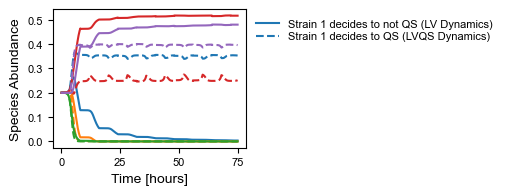

In [24]:
file='final_results_2'
file2='figs'

t_in=0
t_f=15000

fig, axs = plt.subplots(1, figsize=(2.5, 1.8), layout='constrained', sharex=True)

plt.rcParams['font.family'] = 'Arial'

density_NQS = np.zeros((len(results_NA[:,0]),num_strains))
density = np.zeros((len(results_NA[:,0]),num_strains))

                   
for i in range(len(results_NA[:,0])):
    for k in range(num_strains):
        density_NQS[i,k]=results_NA[i,k+1]/np.sum(results_NA[i,1:])

for i in range(len(results[:,0])):
    for k in range(num_strains):
        density[i,k]=results[i,k+1]/np.sum(results[i,1:])
    

plt.plot(results_NA[t_in:t_f,0],density_NQS[t_in:t_f,0], color='C0', label='Strain 1 decides to not QS (LV Dynamics)')
plt.plot(results[t_in:t_f,0],density[t_in:t_f,0], color='C0', label='Strain 1 decides to QS (LVQS Dynamics)', linestyle='dashed')

for j in range(num_strains-1):
    plt.plot(results_NA[t_in:t_f,0],density_NQS[t_in:t_f,j+1], color='C'+str(j+1))
    plt.plot(results[t_in:t_f,0],density[t_in:t_f,j+1], linestyle='dashed', color='C'+str(j+1))

plt.tick_params(axis='both', which='both', labelsize=8)

plt.xlabel('Time [hours]', size=10)
plt.ylabel(r'Species Abundance', size=10)

axs.set_xticks([0, 25, 50, 75])
axs.set_xticklabels(['0', r'25', r'50', r'75'])

S_LV = np.count_nonzero(density_NQS[-1,:])

plt.legend(fontsize=8, labelspacing=0.2, frameon=False, bbox_to_anchor=(1, 1))

plt.savefig(file+'/'+file2+'/fig1E.pdf',bbox_inches='tight',format="PDF", dpi=900)

plt.show()